Black-Litterman is a method of portfolio optimization that leverages bayesian statistics to generate better results


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

tickers = ["EEM", "EFA", "IJR", "SPY", "AGG", "JNK", "SHY"]

ohlc = yf.download(tickers, period="max")
prices = ohlc["Adj Close"]
print(prices.head())
print(prices.tail())

[*********************100%***********************]  7 of 7 completed
            AGG  EEM  EFA  IJR  JNK  SHY        SPY
Date                                               
1993-01-29  NaN  NaN  NaN  NaN  NaN  NaN  25.799770
1993-02-01  NaN  NaN  NaN  NaN  NaN  NaN  25.983273
1993-02-02  NaN  NaN  NaN  NaN  NaN  NaN  26.038315
1993-02-03  NaN  NaN  NaN  NaN  NaN  NaN  26.313566
1993-02-04  NaN  NaN  NaN  NaN  NaN  NaN  26.423655
                   AGG        EEM        EFA         IJR         JNK  \
Date                                                                   
2021-08-10  115.430000  52.180000  80.449997  111.620003  108.650002   
2021-08-11  115.540001  52.320000  81.000000  112.400002  108.830002   
2021-08-12  115.550003  51.860001  80.930000  111.830002  108.970001   
2021-08-13  115.970001  51.730000  81.419998  111.010002  109.160004   
2021-08-16  116.029999  51.259998  81.000000  110.459999  109.190002   

                  SHY         SPY  
Date                      

In [6]:
market_prices = yf.download("SPY", period="max")["Adj Close"]
market_prices.head()

[*********************100%***********************]  1 of 1 completed


Date
1993-01-29    25.799770
1993-02-01    25.983273
1993-02-02    26.038315
1993-02-03    26.313566
1993-02-04    26.423655
Name: Adj Close, dtype: float64

In [4]:
import pypfopt
pypfopt.__version__

'1.4.2'

In [7]:
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(market_prices)
print(delta)

2.76889809991177


THe covariance shrinkage is a method of evening out extreme instances of covariance by reducing the impact of extreme outliers.

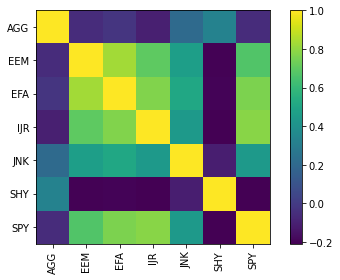

In [8]:
plotting.plot_covariance(S, plot_correlation=True);

In [11]:
mcaps = {}
for t in tickers:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info["totalAssets"]
print(mcaps)

{'EEM': 30331127808, 'EFA': 56765460480, 'IJR': 68639125504, 'SPY': 374031319040, 'AGG': 88802074624, 'JNK': 9782642688, 'SHY': 19510605824}


Normally we would use Market Cap, here we're using 'totalAssets' because we're only evaluating ETF's and this will give use net assets which is a good substitute.

In [12]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
print(market_prior)

AGG    0.019655
EEM    0.091505
EFA    0.082241
IJR    0.090461
JNK    0.037744
SHY    0.018695
SPY    0.095155
dtype: float64


We can now input our predictions and confidence in next year's asset movements

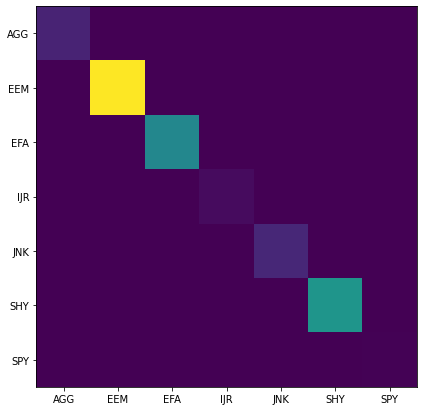

In [14]:
# You don't have to provide views on all the assets
viewdict = {
    "EEM": 0.10,
    "EFA": 0.08,
    "IJR": 0.09,
    "SPY": 0.15,
    "AGG": 0.01,
    "JNK": -0.04,
    "SHY": 0.01
}

bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict)

confidences = [
    0.8,
    0.2,
    0.4,
    0.9,
    0.1, 
    0.1,
    0.3
]


bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)

fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(bl.omega)

# We want to show all ticks...
ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

In [19]:
#bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_aversion=delta,
#                        absolute_views=viewdict, omega=omega)

ret_bl = bl.bl_returns()
print(ret_bl)

AGG    0.015890
EEM    0.106960
EFA    0.101794
IJR    0.116920
JNK    0.037308
SHY    0.015700
SPY    0.141043
dtype: float64


In [18]:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)], 
             index=["Prior", "Posterior", "Views"]).T
print(rets_df)

        Prior  Posterior  Views
AGG  0.019655   0.015890   0.01
EEM  0.091505   0.106960   0.10
EFA  0.082241   0.101794   0.08
IJR  0.090461   0.116920   0.09
JNK  0.037744   0.037308  -0.04
SHY  0.018695   0.015700   0.01
SPY  0.095155   0.141043   0.15


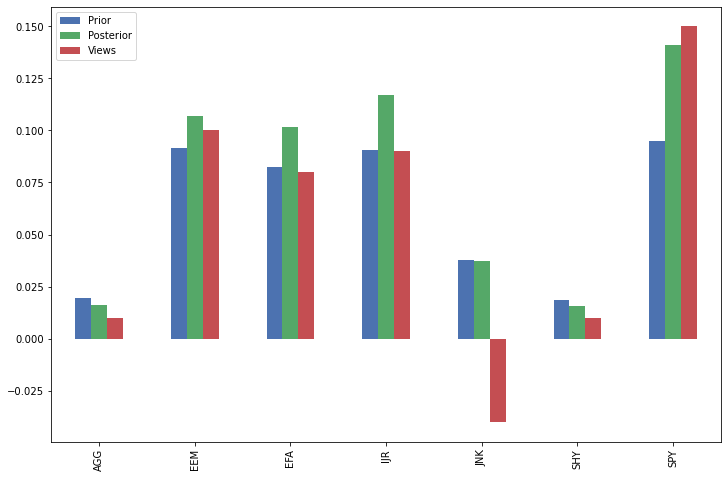

In [20]:
rets_df.plot.bar(figsize=(12,8));

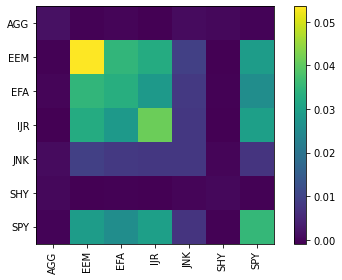

In [22]:
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);

In [23]:
from pypfopt import EfficientFrontier, objective_functions

ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
print(weights)

OrderedDict([('AGG', 0.0), ('EEM', 0.20872), ('EFA', 0.20051), ('IJR', 0.24014), ('JNK', 0.0405), ('SHY', 0.0), ('SPY', 0.31013)])


/opt/anaconda3/lib/python3.8/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:252: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


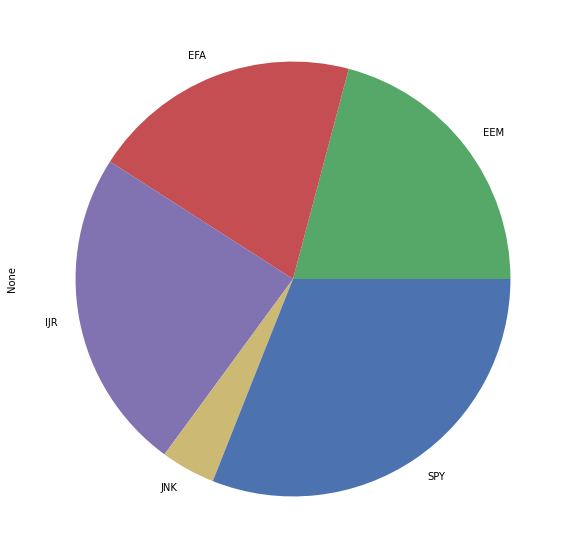

In [24]:
pd.Series(weights).plot.pie(figsize=(10,10));